<a href="https://colab.research.google.com/github/sirius70/NLP_HW3/blob/main/bert_probe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probling Language Model Representations

In this notebook, you will explore how much information language models have about linguistic structure even when they have not been explicitly trained to predict it. You will use the encoder language model BERT.

This is a kind of experiment called &ldquo;probing&rdquo;, where we use internal representations from a language model to predict certain information we have but the language model does not. In particular, we will use a named entity recognition (NER) task, `BIO` tags on each word for the classes person, location, organization, and miscellaneous. The base BERT model did not see any of these labels in training—although BERT has often been fine-tuned on token labeling tasks. For more on token classification for named entity recognition, and for some of the code we use here, see [this huggingface tutorial](https://huggingface.co/docs/transformers/en/tasks/token_classification).

Work through the notebook and complete the cells marked TODO to set up and run these experiments.

We start by installing the huggingface `transformers` and related libraries.

In [1]:
!pip install transformers datasets evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In case you want them later, we'll load the sklearn functions you used for training logistic regression in assignment 2.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, LeaveOneOut, KFold
import numpy as np

Then, we'll use the huggingface `datasets` library to download the CoNLL (Conference on Natural Language Learning) 2003 data for named-entity recognition.

In [3]:
from datasets import load_dataset
conll2003 = load_dataset("hgissbkh/conll2003-en")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/776 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/838k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/212k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/192k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3252 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3454 [00:00<?, ? examples/s]

To keep things simple, we'll work with a sample of 1000 sentences.

In [4]:
sample = conll2003['train'].select(range(1000))

Each record contains a list of word tokens and a list of NER labels. For efficiency, the labels have been turned into integers, which makes them hard to interpret.

In [5]:
sample[0]

{'words': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner': [4, 0, 8, 0, 0, 0, 8, 0, 0]}

Fortunately, the dataset object also contains information to map these integers back to readable strings. We can see tags such as `B-PER` (the beginning token of a personal name), `I-PER` (the following tokens inside a personal name, if any), and `O` (a token outside any named entities). We create two dictionaries `id2label` and `label2id` to make mapping between integers and labels easier.

In [6]:
labels = sample.features['ner'].feature.names
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}
print(labels)
print(id2label)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


For a language model to interpret our data properly, we need to tokenize it in the same way as its training data. We download the tokenizer for the `bert-base-cased` model from huggingface.

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Let's see what happens when we run the tokenizer on a single sentence. We tell it that our sentence has already been split into words, in this case by the creators of the CoNLL 2003 NER dataset. BERT, like many language models, used **subword tokenization** to keep the size of its vocabulary manageable. The tokenizer turns $n$ words into $m \ge n$ tokens, represented as a list of integer token identifiers. We use the method `convert_ids_to_tokens` to turn these integers back into a string representation.

In [8]:
example = sample[10]
tokenized_input = tokenizer(example['words'], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
tokens

['[CLS]',
 'Spanish',
 'Farm',
 'Minister',
 'Loyola',
 'de',
 'Pa',
 '##la',
 '##cio',
 'had',
 'earlier',
 'accused',
 'Fi',
 '##sch',
 '##ler',
 'at',
 'an',
 'EU',
 'farm',
 'ministers',
 "'",
 'meeting',
 'of',
 'causing',
 'un',
 '##ju',
 '##st',
 '##ified',
 'alarm',
 'through',
 '"',
 'dangerous',
 'general',
 '##isation',
 '.',
 '"',
 '[SEP]']

Notice how the name `Palacio` has been split into three subword tokens: `Pa`, `##la`, and `##cio`. The prepended `##` indicates that this token is _not_ the start of a word. But the NER annotations we have are at the word level. We thus need to do some work to map the sequence of NER labels, linked to words, to the usually longer sequence of subword tokens. This is a common task when you have data that wasn't created for a particular language model's classification. We adapt a function from the huggingface tutorial to map the NER labels onto the subword tokens. We assign the label -100 to tokens not at the beginning of a word, as well as to the sentinel `[CLS]` and `[SEP]` tokens at the beginning and end of the sentence.

In [9]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['words'], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples['ner']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs

We apply this function to the whole dataset.

In [10]:
tokenized_sample = sample.map(tokenize_and_align_labels, batched=True)
tokenized_sample.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Each record in the tokenized sample now has numeric IDs for each token, an attention mask (always 1 in this encoding task), and token-level labels.

In [11]:
tokenized_sample[0]

{'input_ids': tensor([  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([-100,    4,    0,    8,    0,    0,    0,    8,    0, -100,    0, -100])}

Now let's load the BERT model itself. We use the version that was trained on data that hadn't been case-folded, since upper-case words might be useful features for NER in English.

In [12]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased", output_hidden_states=True)

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

We run inference on the first sentence in our sample, passing the model the list of token identifiers (coerced into a tensor with a single batch dimension) and the attention mask, which is all 1s for this simple encoding task.

In [13]:
import torch
with torch.no_grad():
  outputs = model(input_ids=tokenized_sample[0]['input_ids'].unsqueeze(0), attention_mask=tokenized_sample[0]['attention_mask'].unsqueeze(0))
  hidden_states = outputs.hidden_states

The `hidden_states` object we just created is a tuple with 13 items, one for each layer of the BERT model. The initial token embedding is layer 0 and the output is layer 12. Each layer contains embeddings for each token&mdash;here, there are 12&mdash;each of which is a vector of length 768.

In [14]:
print(len(hidden_states))
print(hidden_states[0].shape)

13
torch.Size([1, 12, 768])


We now define a function to take a dataset of tokens, run it through BERT to produce embeddings at all 13 layers, and to produce features for predicting NER labels from token embeddings. This function uses two explicit nested loops, which is not the fastest way to do things in pytorch, but more clearly expresses what is being computed. It takes about a minute to run on colab. (This assignment isn't meant to be a pytorch tutorial, but if you know pytorch, or are learning it, feel free to speed up this code by batching the examples together.)

In [15]:
def compute_layer_representation(data, model, tokenizer):
  rep = []
  lab = []
  for example in data:
    with torch.no_grad():
      outputs = model(input_ids=example['input_ids'].unsqueeze(0), attention_mask=example['attention_mask'].unsqueeze(0))
      tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
      hidden_states = outputs.hidden_states
      for i in range(len(example['labels'])):
        if example['labels'][i] != -100:
          lab.append(int(example['labels'][i]))
          rep.append([hidden_states[layer][0][i].numpy() for layer in range(len(hidden_states))])
          #rep.append(hidden_states[layer][0][i].numpy())
  return [np.array(rep), np.array(lab)]

We compute embeddings for all layers for the full dataset. Note that the first dimension is now _words_ rather then sentences. This means that we can probe the information that each word's embedding has about named entities (or anything else).

In [16]:
X, y = compute_layer_representation(tokenized_sample, model, tokenizer)

We can select information about the bottom (word embedding) layer, which gives as a matrix of words by embedding dimensions.

In [17]:
X[:,0,:].shape

(12057, 768)

**TODO:** Your first task is to probe the information that these emedding layers have about named entities. Train one linear model for each of the 13 layers of BERT to predict the label of each word in `y` using the embeddings in `X`. Print the accuracy of this model for each of the 13 layers of BERT. By accuracy, we simply mean the proportion of words that have been assigned the correct tag. (Although NER is often evaluated at the level of the entity, which may span one or more words, we will keep things simple here.)

You may use the sklearn code for training logistic regression models that you ran in assignment 2. You may also train these classifiers using pytorch. In any case, perform 10-fold cross validation and return the average accuracy over all ten folds.

Training logistic regression probes for each BERT layer...

Layer  0: 0.9249
Layer  1: 0.9502
Layer  2: 0.9571
Layer  3: 0.9584
Layer  4: 0.9662
Layer  5: 0.9690
Layer  6: 0.9723
Layer  7: 0.9725
Layer  8: 0.9716
Layer  9: 0.9715
Layer 10: 0.9721
Layer 11: 0.9725
Layer 12: 0.9699

Average accuracy per BERT layer:
Layer  0: 0.9249
Layer  1: 0.9502
Layer  2: 0.9571
Layer  3: 0.9584
Layer  4: 0.9662
Layer  5: 0.9690
Layer  6: 0.9723
Layer  7: 0.9725
Layer  8: 0.9716
Layer  9: 0.9715
Layer 10: 0.9721
Layer 11: 0.9725
Layer 12: 0.9699


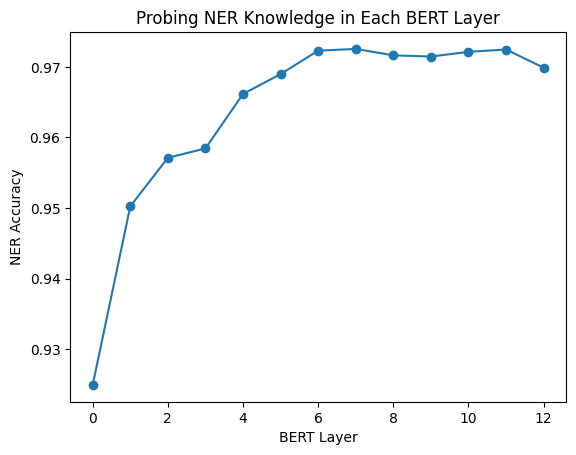

In [18]:
# TODO: Train linear models to predict the NER labels using embeddings from each layer of BERT.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# We have:
# X: shape (num_tokens, 13, 768)
# y: shape (num_tokens,)
# We'll loop through 13 layers (0–12), take X[:, layer, :], and train a classifier.

n_layers = X.shape[1]
kf = KFold(n_splits=10, shuffle=True, random_state=42)

layer_accuracies = []

print("Training logistic regression probes for each BERT layer...\n")

for layer in range(n_layers):
    X_layer = X[:, layer, :]  # Extract embeddings for this layer
    accuracies = []

    for train_index, test_index in kf.split(X_layer):
        X_train, X_test = X_layer[train_index], X_layer[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegression(max_iter=200, solver='lbfgs', n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    mean_acc = np.mean(accuracies)
    layer_accuracies.append(mean_acc)
    print(f"Layer {layer:2d}: {mean_acc:.4f}")

# Print summary
print("\nAverage accuracy per BERT layer:")
for layer, acc in enumerate(layer_accuracies):
    print(f"Layer {layer:2d}: {acc:.4f}")

# Optional: visualize the trend
import matplotlib.pyplot as plt
plt.plot(range(n_layers), layer_accuracies, marker='o')
plt.xlabel("BERT Layer")
plt.ylabel("NER Accuracy")
plt.title("Probing NER Knowledge in Each BERT Layer")
plt.show()


Layer 0: 0.9249
Layer 1: 0.9502
Layer 2: 0.9571
Layer 3: 0.9584
Layer 4: 0.9662
Layer 5: 0.9690
Layer 6: 0.9723
Layer 7: 0.9725
Layer 8: 0.9716
Layer 9: 0.9715
Layer 10: 0.9721
Layer 11: 0.9725
Layer 12: 0.9699


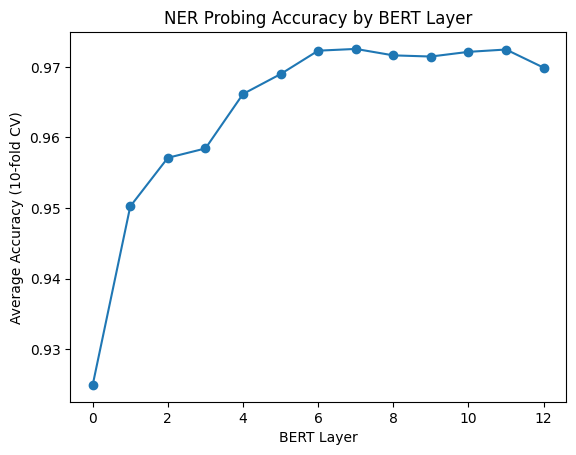

In [19]:
# TODO: Train linear models to predict the NER labels using embeddings from each layer of BERT.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

kf = KFold(n_splits=10, shuffle=True, random_state=42)
layer_accuracies = []

for layer in range(X.shape[1]):
    X_layer = X[:, layer, :]
    accuracies = []
    for train_idx, test_idx in kf.split(X_layer):
        X_train, X_test = X_layer[train_idx], X_layer[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = LogisticRegression(max_iter=200, solver='lbfgs', n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

    mean_acc = np.mean(accuracies)
    layer_accuracies.append(mean_acc)
    print(f"Layer {layer}: {mean_acc:.4f}")

plt.plot(range(len(layer_accuracies)), layer_accuracies, marker='o')
plt.xlabel("BERT Layer")
plt.ylabel("Average Accuracy (10-fold CV)")
plt.title("NER Probing Accuracy by BERT Layer")
plt.show()


**TODO:** How good are these accuracy levels? Since the `O` tag is very common, you can do quite well by always predicting `O`. Compute the baseline accuracy, i.e., the accuracy you would get on the sample data if you always predicted `O`.

In [20]:
# TODO: Compute and print the baseline accuracy of always predicting O.

import numpy as np

# The label ID for 'O' (outside any named entity)
o_label_id = label2id['O']

# Compute how many tokens in y are 'O'
o_count = np.sum(y == o_label_id)

# Compute baseline accuracy: proportion of tokens that are 'O'
baseline_accuracy = o_count / len(y)

print(f"Baseline accuracy (always predicting 'O'): {baseline_accuracy:.4f}")


Baseline accuracy (always predicting 'O'): 0.7650


**TODO:** Now try another probing experiment for capitalized words, a simple feature that, in English, is correlated with named entities. For each word in the sample data, create a feature that indicates whether that word's first character is a capital letter. Then train logistic regression models for each layer of BERT to see how well they predict capitalization. Perform 10-fold cross-validation as above. Note any differences you see with the NER probes.

In addition, compute the baseline accuracy, i.e., the accuracy of always predicting that a word is not capitalized.

Training logistic regression models to predict capitalization...

Layer 0: Accuracy = 1.0000 (std = 0.0000)
Layer 1: Accuracy = 1.0000 (std = 0.0000)
Layer 2: Accuracy = 1.0000 (std = 0.0000)
Layer 3: Accuracy = 0.9999 (std = 0.0002)
Layer 4: Accuracy = 0.9999 (std = 0.0002)
Layer 5: Accuracy = 0.9996 (std = 0.0004)
Layer 6: Accuracy = 0.9997 (std = 0.0004)
Layer 7: Accuracy = 0.9990 (std = 0.0005)
Layer 8: Accuracy = 0.9990 (std = 0.0008)
Layer 9: Accuracy = 0.9984 (std = 0.0012)
Layer 10: Accuracy = 0.9982 (std = 0.0010)
Layer 11: Accuracy = 0.9977 (std = 0.0021)
Layer 12: Accuracy = 0.9974 (std = 0.0017)

Baseline accuracy (always predicting 'not capitalized'): 0.6985

Summary of capitalization accuracies across layers:
Layer  0: 1.0000
Layer  1: 1.0000
Layer  2: 1.0000
Layer  3: 0.9999
Layer  4: 0.9999
Layer  5: 0.9996
Layer  6: 0.9997
Layer  7: 0.9990
Layer  8: 0.9990
Layer  9: 0.9984
Layer 10: 0.9982
Layer 11: 0.9977
Layer 12: 0.9974

Best layer: Layer 0 with accuracy 1.0000


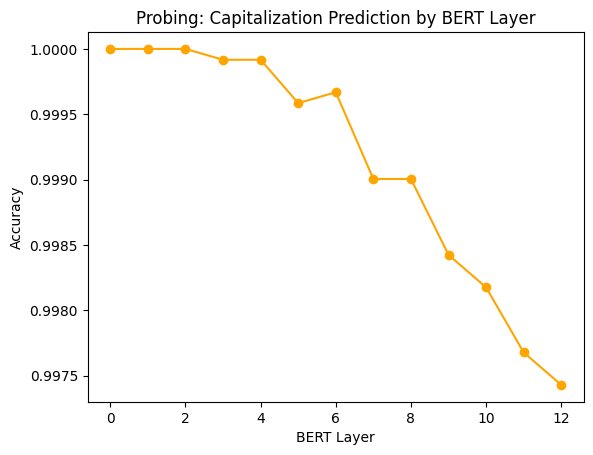

In [21]:
# TODO: Train linear models to predict capitalization.
# Compute and print the accuracy of these models for each layer of BERT.
# Compute and print the baseline accuracy.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# --- Step 1: Create binary capitalization labels for each token ---
# We'll use the original words from the sample to determine if the first character is uppercase.

capitalization_labels = []
for example in sample:
    for word in example['words']:
        if word and word[0].isupper():
            capitalization_labels.append(1)
        else:
            capitalization_labels.append(0)

capitalization_labels = np.array(capitalization_labels)

# Check alignment (should match y length)
assert len(capitalization_labels) == len(y), "Mismatch between labels and tokens!"

# --- Step 2: Train logistic regression models on each BERT layer ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cap_layer_accuracies = []

print("Training logistic regression models to predict capitalization...\n")

for layer in range(X.shape[1]):
    X_layer = X[:, layer, :]
    scores = cross_val_score(
        LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1, random_state=42),
        X_layer,
        capitalization_labels,
        cv=kf,
        scoring='accuracy'
    )
    mean_acc = scores.mean()
    cap_layer_accuracies.append(mean_acc)
    print(f"Layer {layer}: Accuracy = {mean_acc:.4f} (std = {scores.std():.4f})")

# --- Step 3: Compute baseline accuracy ---
# Most words are not capitalized
non_capitalized = np.sum(capitalization_labels == 0)
baseline_accuracy = non_capitalized / len(capitalization_labels)
print(f"\nBaseline accuracy (always predicting 'not capitalized'): {baseline_accuracy:.4f}")

# --- Step 4: Summarize ---
print("\n" + "="*55)
print("Summary of capitalization accuracies across layers:")
print("="*55)
for layer, acc in enumerate(cap_layer_accuracies):
    print(f"Layer {layer:2d}: {acc:.4f}")
print(f"\nBest layer: Layer {np.argmax(cap_layer_accuracies)} with accuracy {max(cap_layer_accuracies):.4f}")

# --- Step 5: Optional visualization ---
import matplotlib.pyplot as plt
plt.plot(range(X.shape[1]), cap_layer_accuracies, marker='o', color='orange')
plt.xlabel("BERT Layer")
plt.ylabel("Accuracy")
plt.title("Probing: Capitalization Prediction by BERT Layer")
plt.show()


In [ ]:
# TODO: Train linear models to predict the NER labels using embeddings from each layer of BERT.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Store accuracies for each layer
layer_accuracies = []

# Loop through each of the 13 layers
for layer in range(13):
    # Extract embeddings from the current layer
    X_layer = X[:, layer, :]  # Shape: (num_words, 768)

    # Initialize logistic regression model
    # max_iter increased to ensure convergence
    lr_model = LogisticRegression(max_iter=1000, random_state=42)

    # Perform 10-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(lr_model, X_layer, y, cv=kfold, scoring='accuracy')

    # Calculate mean accuracy
    mean_accuracy = scores.mean()
    layer_accuracies.append(mean_accuracy)

    # Print results for this layer
    print(f"Layer {layer}: Accuracy = {mean_accuracy:.4f} (std = {scores.std():.4f})")

# Print summary
print("\n" + "="*50)
print("Summary of accuracies across layers:")
print("="*50)
for layer, acc in enumerate(layer_accuracies):
    print(f"Layer {layer:2d}: {acc:.4f}")
print(f"\nBest layer: Layer {np.argmax(layer_accuracies)} with accuracy {max(layer_accuracies):.4f}")

In [ ]:
# TODO: Compute and print the baseline accuracy of always predicting O.

# Count how many times each label appears
from collections import Counter

label_counts = Counter(y)
print("Label distribution:")
for label_id in sorted(label_counts.keys()):
    label_name = id2label[label_id]
    count = label_counts[label_id]
    percentage = (count / len(y)) * 100
    print(f"  {label_name} (id={label_id}): {count} ({percentage:.2f}%)")

# Compute baseline accuracy (always predicting O)
# O has label id = 0
num_O_tags = label_counts[0]
total_tags = len(y)
baseline_accuracy = num_O_tags / total_tags

print(f"\n{'='*50}")
print(f"Baseline Accuracy (always predicting 'O'): {baseline_accuracy:.4f}")
print(f"{'='*50}")

# Compare with best layer performance
if 'layer_accuracies' in locals():
    best_layer_acc = max(layer_accuracies)
    best_layer = np.argmax(layer_accuracies)
    improvement = best_layer_acc - baseline_accuracy
    print(f"\nBest layer (Layer {best_layer}): {best_layer_acc:.4f}")
    print(f"Improvement over baseline: {improvement:.4f} ({improvement/baseline_accuracy*100:.2f}%)")

In [ ]:
# TODO: Train linear models to predict capitalization.
# Compute and print the accuracy of these models for each layer of BERT.
# Compute and print the baseline accuracy.

# First, create capitalization labels for each word in the dataset
capitalization_labels = []

for example in tokenized_sample:
    tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
    labels = example['labels']

    for i, label in enumerate(labels):
        if label != -100:  # Only process tokens that correspond to first subword of a word
            token = tokens[i]
            # Check if first character is uppercase
            # Exclude special tokens like [CLS], [SEP]
            if token.startswith('[') and token.endswith(']'):
                continue  # Skip special tokens
            is_capitalized = 1 if token[0].isupper() else 0
            capitalization_labels.append(is_capitalized)

y_cap = np.array(capitalization_labels)

print(f"Total words for capitalization task: {len(y_cap)}")
print(f"Number of capitalized words: {y_cap.sum()}")
print(f"Number of non-capitalized words: {len(y_cap) - y_cap.sum()}")

# Compute baseline accuracy (always predicting not capitalized, i.e., 0)
num_not_capitalized = len(y_cap) - y_cap.sum()
baseline_cap_accuracy = num_not_capitalized / len(y_cap)
print(f"\nBaseline Accuracy (always predicting not capitalized): {baseline_cap_accuracy:.4f}")

# Train logistic regression for each layer to predict capitalization
print("\n" + "="*50)
print("Capitalization Prediction Accuracy by Layer")
print("="*50)

cap_layer_accuracies = []

for layer in range(13):
    # Extract embeddings from the current layer
    X_layer = X[:, layer, :]

    # Initialize logistic regression model
    lr_model = LogisticRegression(max_iter=1000, random_state=42)

    # Perform 10-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(lr_model, X_layer, y_cap, cv=kfold, scoring='accuracy')

    # Calculate mean accuracy
    mean_accuracy = scores.mean()
    cap_layer_accuracies.append(mean_accuracy)

    # Print results for this layer
    print(f"Layer {layer}: Accuracy = {mean_accuracy:.4f} (std = {scores.std():.4f})")

# Print summary
print("\n" + "="*50)
print("Summary: Capitalization vs NER")
print("="*50)
print(f"Baseline (always not capitalized): {baseline_cap_accuracy:.4f}")
print(f"Best capitalization layer: Layer {np.argmax(cap_layer_accuracies)} with accuracy {max(cap_layer_accuracies):.4f}")
if 'layer_accuracies' in locals():
    print(f"\nBaseline (always O for NER): {baseline_accuracy:.4f}")
    print(f"Best NER layer: Layer {np.argmax(layer_accuracies)} with accuracy {max(layer_accuracies):.4f}")

# Optional: Plot comparison
print("\n" + "="*50)
print("Observations:")
print("="*50)
print("Compare the accuracies for capitalization vs NER across layers.")
print("Note which layers perform best for each task and how much they")
print("improve over their respective baselines.")